In [1]:
import sys
sys.path.insert(0,'..')
import oqupy
import numpy as np
import matplotlib.pyplot as plt
from oqupy import contractions

from scipy import special

In [2]:
alpha = 0.25
nu_c = 0.15 #0.15*1000 # 227.9
T = 0.026   #0.026*1000 # 39.3
omega_c = 0.0
#omega_0_list = [] #omega_0 = 0.0 # CHANGES
Omega = 0.2        #0.2 # 303.9
kappa = 0.01       #0.01*1000 #15.2
Gamma_down = 0.01  #0.01*1000 #30.4
Gamma_up = 0.01    #0.01*1000 #0.8 * Gamma_down

sigma_z = oqupy.operators.sigma("z")
sigma_plus = oqupy.operators.sigma("+")
sigma_minus = oqupy.operators.sigma("-")

gammas = [lambda t: Gamma_down, lambda t: Gamma_up]
lindblad_operators = [lambda t: sigma_minus, lambda t: sigma_plus]

initial_field = np.sqrt(0.05)               # Note n_0 = <a^dagger a>(0) = 0.05
initial_state = np.array([[0,0],[0,1]])     # spin down

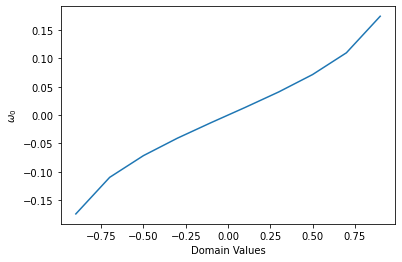

In [3]:
# define list of possible main values for omega_0 of individual systems
omega_0_list = [0.05, 0.1, 0.4, 0.5, 0.8, 1]
omega_0_list = [nu_c*i for i in omega_0_list]


# plot sample values for systems within a super-system
sample__omega_0 = omega_0_list[5]
value_range = np.linspace(-0.9, 0.9, num=10)
plt.xlabel(r'Domain Values')
plt.ylabel(r'$\omega_0$')
plt.plot(value_range, sample__omega_0*special.erfinv(value_range))

In [4]:
# define process tensor

correlations = oqupy.PowerLawSD(alpha=alpha,
                                zeta=1,
                                cutoff=nu_c,
                                cutoff_type='gaussian',
                                temperature=T)

bath = oqupy.Bath(0.5 * sigma_z, correlations)

tempo_parameters = oqupy.TempoParameters(dt=0.5, dkmax=20, epsrel=10**(-5))
start_time = 0.0
end_time = 80 #1.5

process_tensor = oqupy.pt_tempo_compute(bath=bath,
                                        start_time=start_time,
                                        end_time=end_time,
                                        parameters=tempo_parameters)


--> PT-TEMPO computation:
100.0%  160 of  160 [########################################] 00:00:07
Elapsed time: 7.3s


In [5]:
num_systems = 20 # number of systems within a super-system

initial_state_list = [initial_state for i in range(num_systems)]
fractions = [1/num_systems for i in range(num_systems)]

# define field equation of motion of super-system
def field_eom(t, states, field):
    sx_exp_list = [np.matmul(sigma_minus, state).trace() for state in states]
    sx_exp_weighted_sum = sum([fraction*sx_exp for fraction, sx_exp in zip(fractions, sx_exp_list)])
    return -(1j*omega_c+kappa)*field - 0.5j*Omega*sx_exp_weighted_sum

# define field equation of motion for single system within super-system
def single_field_eom(t, state, a):
        expect_val = np.matmul(sigma_minus, state).trace()
        return -(1j * omega_c + kappa) * a - 0.5j * Omega * expect_val

# define domain of values over which inverse error fucntion will be taken
value_range = np.linspace(-0.9, 0.9, num=num_systems)

# initialize list of super systems
super_system_list = []

for omega_0 in omega_0_list:

    system_omega_0_values = omega_0*special.erfinv(value_range)
    system_list = []

    for omega_0_val in system_omega_0_values:

        # define mean field Hamiltonian 
        # (taking care to avoid late binding issue: https://docs.python-guide.org/writing/gotchas/#late-binding-closures)
        def H_MF(t, a, omega_0_val=omega_0_val):
            return 0.5 * omega_0_val * sigma_z +\
                0.5 * Omega * (a * sigma_plus + np.conj(a) * sigma_minus)

        system = oqupy.TimeDependentSystemWithField(
                    hamiltonian=H_MF,
                    field_eom=single_field_eom,
                    gammas=gammas,
                    lindblad_operators=lindblad_operators)

        system_list.append(system)
    
    super_system = oqupy.SuperTimeDependentSystemWithField(system_list, field_eom=field_eom)
    super_system_list.append(super_system)

In [6]:
"""# compute dynamics of super-systems
super_t_list =[]
super_n_list = []
for super_sytem in super_system_list:
    t_list = []
    n_list = []
    super_system_dynamics = contractions.compute_dynamics_with_field_multiple_systems(system=super_system, initial_field=initial_field, 
                                                                                    initial_state_list=initial_state_list, 
                                                                                    start_time=start_time,
                                                                                    process_tensor_list = process_tensor
                                                                                    )
    for dynamics in super_system_dynamics.dynamics_list:
        t_list.append(dynamics.times)
        n_list.append(np.abs(dynamics.fields)**2)
    
    super_t_list.append(t_list)
    super_n_list.append(n_list)
    
for i, (t_list, n_list) in enumerate(zip(super_t_list, super_n_list)):
    # plot dynamics of first system in super-system 
    # (all should give the same plot in this case)
    label = f"Super-System {i}, main_omega_0 = {'{:.3f}'.format(omega_0_list[i])}"
    plt.plot(t_list[0], n_list[0], label=label)

plt.xlabel(r'$t$ (ps)')
plt.ylabel(r'$n/N$')
plt.legend(loc='best') 


    

#plt.tight_layout()


#plt.ylim((0.04999995,0.05))
#plt.xlim((0,0.00125))

#plt.title(f"Super-System {i}, main_omega_0 = {'{:.2f}'.format(omega_0_list[i])}")
#plt.savefig(f"Super-System {i}, main_omega_0 = {'{:.2f}'.format(omega_0_list[i])}.png")"""

'# compute dynamics of super-systems\nsuper_t_list =[]\nsuper_n_list = []\nfor super_sytem in super_system_list:\n    t_list = []\n    n_list = []\n    super_system_dynamics = contractions.compute_dynamics_with_field_multiple_systems(system=super_system, initial_field=initial_field, \n                                                                                    initial_state_list=initial_state_list, \n                                                                                    start_time=start_time,\n                                                                                    process_tensor_list = process_tensor\n                                                                                    )\n    for dynamics in super_system_dynamics.dynamics_list:\n        t_list.append(dynamics.times)\n        n_list.append(np.abs(dynamics.fields)**2)\n    \n    super_t_list.append(t_list)\n    super_n_list.append(n_list)\n    \nfor i, (t_list, n_list) in enumerate(zip(super

--> Compute dynamics with field:
100.0%  160 of  160 [########################################] 00:02:12
Elapsed time: 132.5s
--> Compute dynamics with field:
100.0%  160 of  160 [########################################] 00:02:08
Elapsed time: 128.6s
--> Compute dynamics with field:
100.0%  160 of  160 [########################################] 00:02:08
Elapsed time: 128.5s
--> Compute dynamics with field:
100.0%  160 of  160 [########################################] 00:02:10
Elapsed time: 130.2s
--> Compute dynamics with field:
100.0%  160 of  160 [########################################] 00:02:10
Elapsed time: 130.8s
--> Compute dynamics with field:
100.0%  160 of  160 [########################################] 00:02:13
Elapsed time: 133.5s


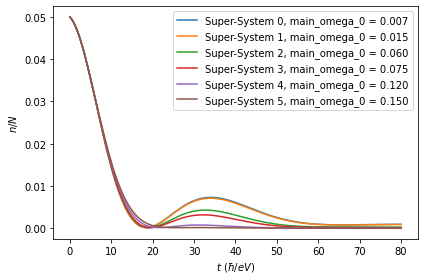

In [7]:
for i, super_system in enumerate(super_system_list):
    t_list = []
    n_list = []
    super_system_dynamics = contractions.compute_dynamics_with_field_multiple_systems(system=super_system, initial_field=initial_field, 
                                                                                    initial_state_list=initial_state_list, 
                                                                                    start_time=start_time,
                                                                                    process_tensor_list = process_tensor
                                                                                    )
    for dynamics in super_system_dynamics.dynamics_list:
        t_list.append(dynamics.times)
        n_list.append(np.abs(dynamics.fields)**2)

    # plot dynamics of first system in super-system 
    # (all should give the same plot in this case)
    label = f"Super-System {i}, main_omega_0 = {'{:.3f}'.format(omega_0_list[i])}"
    plt.plot(t_list[0], n_list[0], label=label)
        
    plt.xlabel(r'$t$ ($\hbar/eV$)')
    plt.ylabel(r'$n/N$')
    plt.tight_layout()
    plt.legend(loc='best') 

--> Compute dynamics with field:
100.0%  160 of  160 [########################################] 00:00:16
Elapsed time: 16.6s
--> Compute dynamics with field:
100.0%  160 of  160 [########################################] 00:00:39
Elapsed time: 39.1s
--> Compute dynamics with field:
100.0%  160 of  160 [########################################] 00:01:15
Elapsed time: 75.3s
--> Compute dynamics with field:
100.0%  160 of  160 [########################################] 00:02:34
Elapsed time: 154.2s


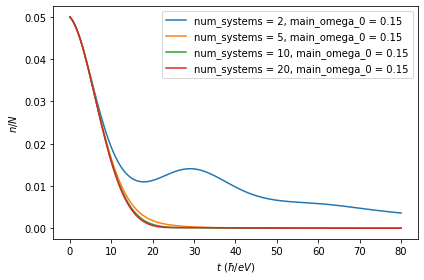

In [13]:
num_systems_list = [2, 5, 10, 20]


def plot_dynamics(omega_0_var, num_systems):
    """Plots dynamics for a super-system with a given omega_0_var
    """
    initial_state_list = [initial_state for i in range(num_systems)]
    fractions = [1/num_systems for i in range(num_systems)]

    # define field equation of motion of super-system
    def field_eom(t, states, field):
        sx_exp_list = [np.matmul(sigma_minus, state).trace() for state in states]
        sx_exp_weighted_sum = sum([fraction*sx_exp for fraction, sx_exp in zip(fractions, sx_exp_list)])
        return -(1j*omega_c+kappa)*field - 0.5j*Omega*sx_exp_weighted_sum

    # define field equation of motion for single system within super-system
    def single_field_eom(t, state, a):
            expect_val = np.matmul(sigma_minus, state).trace()
            return -(1j * omega_c + kappa) * a - 0.5j * Omega * expect_val

    # define domain of values over which inverse error fucntion will be taken
    value_range = np.linspace(-0.9, 0.9, num=num_systems)

    system_omega_0_values = omega_0_var*special.erfinv(value_range)
    system_list = []

    for omega_0_val in system_omega_0_values: # TODO: index from 1 to -2 to exclude endpoints (inifnity and -infinity) 
                                              # if list has more than 2 elements

        # define mean field Hamiltonian 
        # (taking care to avoid late binding issue: https://docs.python-guide.org/writing/gotchas/#late-binding-closures)
        def H_MF(t, a, omega_0_val=omega_0_val):
            return 0.5 * omega_0_val * sigma_z +\
                0.5 * Omega * (a * sigma_plus + np.conj(a) * sigma_minus)

        system = oqupy.TimeDependentSystemWithField(
                    hamiltonian=H_MF,
                    field_eom=single_field_eom,
                    gammas=gammas,
                    lindblad_operators=lindblad_operators)

        system_list.append(system)
    
    super_system = oqupy.SuperTimeDependentSystemWithField(system_list, field_eom=field_eom)

    # plot graphs
    t_list = []
    n_list = []
    super_system_dynamics = contractions.compute_dynamics_with_field_multiple_systems(system=super_system, initial_field=initial_field, 
                                                                                    initial_state_list=initial_state_list, 
                                                                                    start_time=start_time,
                                                                                    process_tensor_list = process_tensor
                                                                                    )
    for dynamics in super_system_dynamics.dynamics_list:
        t_list.append(dynamics.times)
        n_list.append(np.abs(dynamics.fields)**2)

    # plot dynamics of first system in super-system 
    # (all should give the same plot in this case)
    label = f"num_systems = {num_systems}, main_omega_0 = {omega_0_var}"
    plt.plot(t_list[0], n_list[0], label=label)
    plt.xlabel(r'$t$ ($\hbar/eV$)')
    plt.ylabel(r'$n/N$')
    plt.tight_layout()
    plt.legend(loc='best') 

for num_systems in num_systems_list:
    plot_dynamics(omega_0_list[5], num_systems)




In [9]:
"""# test with 4th super-system
super_system_dynamics = contractions.compute_dynamics_with_field_multiple_systems(super_system_list[4], initial_field=initial_field, 
                                                                                    initial_state_list=initial_state_list, 
                                                                                    start_time=start_time,
                                                                                    process_tensor_list = process_tensor
                                                                                    )
t_list = []
n_list = []
for dynamics in super_system_dynamics.dynamics_list:
    t_list.append(dynamics.times)
    n_list.append(np.abs(dynamics.fields)**2)
    
for i in range(len(n_list)):
    label = f"System {i}"
    plt.plot(t_list[i], n_list[i], label=label)

plt.xlabel(r'$t$ (ps)')
plt.ylabel(r'$n/N$')
plt.tight_layout()
#plt.ylim((0.0,0.15))
plt.title(f"Super-System 4, main_omega_0 = {'{:.2f}'.format(omega_0_list[4])}")
plt.legend(loc='lower right') 
plt.savefig(f"Super-System 4, main_omega_0 = {'{:.2f}'.format(omega_0_list[4])}.png")"""

'# test with 4th super-system\nsuper_system_dynamics = contractions.compute_dynamics_with_field_multiple_systems(super_system_list[4], initial_field=initial_field, \n                                                                                    initial_state_list=initial_state_list, \n                                                                                    start_time=start_time,\n                                                                                    process_tensor_list = process_tensor\n                                                                                    )\nt_list = []\nn_list = []\nfor dynamics in super_system_dynamics.dynamics_list:\n    t_list.append(dynamics.times)\n    n_list.append(np.abs(dynamics.fields)**2)\n    \nfor i in range(len(n_list)):\n    label = f"System {i}"\n    plt.plot(t_list[i], n_list[i], label=label)\n\nplt.xlabel(r\'$t$ (ps)\')\nplt.ylabel(r\'$n/N$\')\nplt.tight_layout()\n#plt.ylim((0.0,0.15))\nplt.title(f"Super-Syst